In [1]:
%cd ../..
# %pip install .
import time
from os import environ
# offset = Uniform(-1, 1) * Range(90, 180) deg

# ego = Car on drivableRoad,
#         facing offset relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# otherCar = Car on visible road,
#             facing Range(-15, 15) deg relative to roadDirection

# require (distance from ego to otherCar) < 10

/home/eecs/chanwutk/Documents/apperception


In [2]:
if environ["AP_PORT"] is None:
    environ["AP_PORT"] = str(input('port'))

In [3]:
"""
with (
  select *
  from item_traj
  where item_traj.object_type = 'car'
) as cars

select *
from cars as otherCar
join Cameras as cam on t1.cameraId = Cameras.id
where
  TODO: ego facing relative to road direction????
  DISTANCE(cam.egoTranslation, otherCar.trajCentroids, cam.timestamp) < 50 AND
  viewAngle(otherCar.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND
  contained(otherCar.traj, road_segment_type("visibleRoad"), cam.timestamp) and
  facingRelative(otherCar.heading, road_direction(valueAtTimestamp(otherCar.trajCentroids, cam.timestamp)), cam.timestamp) >= -15 AND
  facingRelative(otherCar.heading, road_direction(valueAtTimestamp(otherCar.trajCentroids, cam.timestamp)), cam.timestamp) < 15 AND
  DISTANCE(cam.egoTranslation, otherCar.centroid, cam.timestamp) < 10 AND
"""

'\nwith (\n  select *\n  from item_traj\n  where item_traj.object_type = \'car\'\n) as cars\n\nselect *\nfrom cars as otherCar\njoin Cameras as cam on t1.cameraId = Cameras.id\nwhere\n  TODO: ego facing relative to road direction????\n  DISTANCE(cam.egoTranslation, otherCar.trajCentroids, cam.timestamp) < 50 AND\n  viewAngle(otherCar.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND\n  contained(otherCar.traj, road_segment_type("visibleRoad"), cam.timestamp) and\n  facingRelative(otherCar.heading, road_direction(valueAtTimestamp(otherCar.trajCentroids, cam.timestamp)), cam.timestamp) >= -15 AND\n  facingRelative(otherCar.heading, road_direction(valueAtTimestamp(otherCar.trajCentroids, cam.timestamp)), cam.timestamp) < 15 AND\n  DISTANCE(cam.egoTranslation, otherCar.centroid, cam.timestamp) < 10 AND\n'

In [4]:
from apperception.world import empty_world
from apperception.utils import F
from apperception.database import database
from apperception.predicate import camera, objects
import numpy as np
database

In [5]:
name = 'ScenicWorld' # world name
world = empty_world(name=name)

# world = world.filter("lambda obj1, cam: " + 
#         "F.like(obj1.object_type, 'vehicle%') and " +
#         "F.distance(cam.ego, obj1, cam.timestamp) < 50 and " +
#         "F.view_angle(obj1, cam.ego, cam.timestamp) < 70 / 2 and " +
#         "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -180, -90) and " +
#         "F.contained(cam.ego, F.road_segment('road')) and " +
#         "F.contained(obj1.traj, F.road_segment('road'), cam.timestamp) and " +
#         "F.angle_between(F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
#         "F.distance(cam.ego, obj1, cam.timestamp) < 10"
# )

obj1 = objects[0]
cam = camera
world = world.filter(
    F.like(obj1.type, 'vehicle%') &
    (F.distance(cam.ego, obj1.trans@cam.timestamp) < 50) &
    (F.view_angle(obj1.trans@cam.time, cam.ego) < 70 / 2) &
    F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -180, -90) &
    F.contained(cam.ego, F.road_segment('road')) &
    F.contained(obj1.trans@cam.time, F.road_segment('road')) &
    F.angle_between(F.facing_relative(obj1.trans@cam.time, F.road_direction(obj1.traj@cam.time, cam.ego)), -15, 15) &
    (F.distance(cam.ego, obj1.trans@cam.time) < 10)
)

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename = world.get_id_time_camId_filename(num_joined_tables=1)

end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT t0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as t0
        
        JOIN Cameras USING (cameraId)
        WHERE (t0.objectType LIKE 'vehicle%' AND (distance(egoTranslation,valueAtTimestamp(t0.translations,timestamp))<50) AND (viewAngle(valueAtTimestamp(t0.translations,timestamp),egoHeading,egoTranslation)<35.0) AND angleBetween(facingRelative(egoHeading, roadDirection(egoTranslation,egoHeading)),-180,-90) AND contained(egoTranslation,roadSegment('road')) AND contained(valueAtTimestamp(t0.translations,timestamp),roadSegment('road')) AND angleBetween(facingRelative((valueAtTimestamp(t0.itemHeadings,timestamp))::real, roadDirection(valueAtTimestamp(t0.trajCentroids,timestamp),egoHeading)),-15,15) AND (distance(egoTranslation,valueAtTimestamp(t0.translations,timestamp))<10))
        
done execute node
Result length: 2
4.3307

In [6]:
resultImages = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename:
    itemId, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    resultImages[filename] = (itemId, timestamp, camId)

In [9]:
from show_images import show_images
%matplotlib inline

# data_dir =  "data/nuscenes/experiment_data"
data_dir = '/work/apperception/data/nuScenes/full-dataset-v1.0/Trainval/experiment_data'
# data_dir = '/Users/chanwutk/Documents/experiment_data'

image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492112404.jpg
loaded


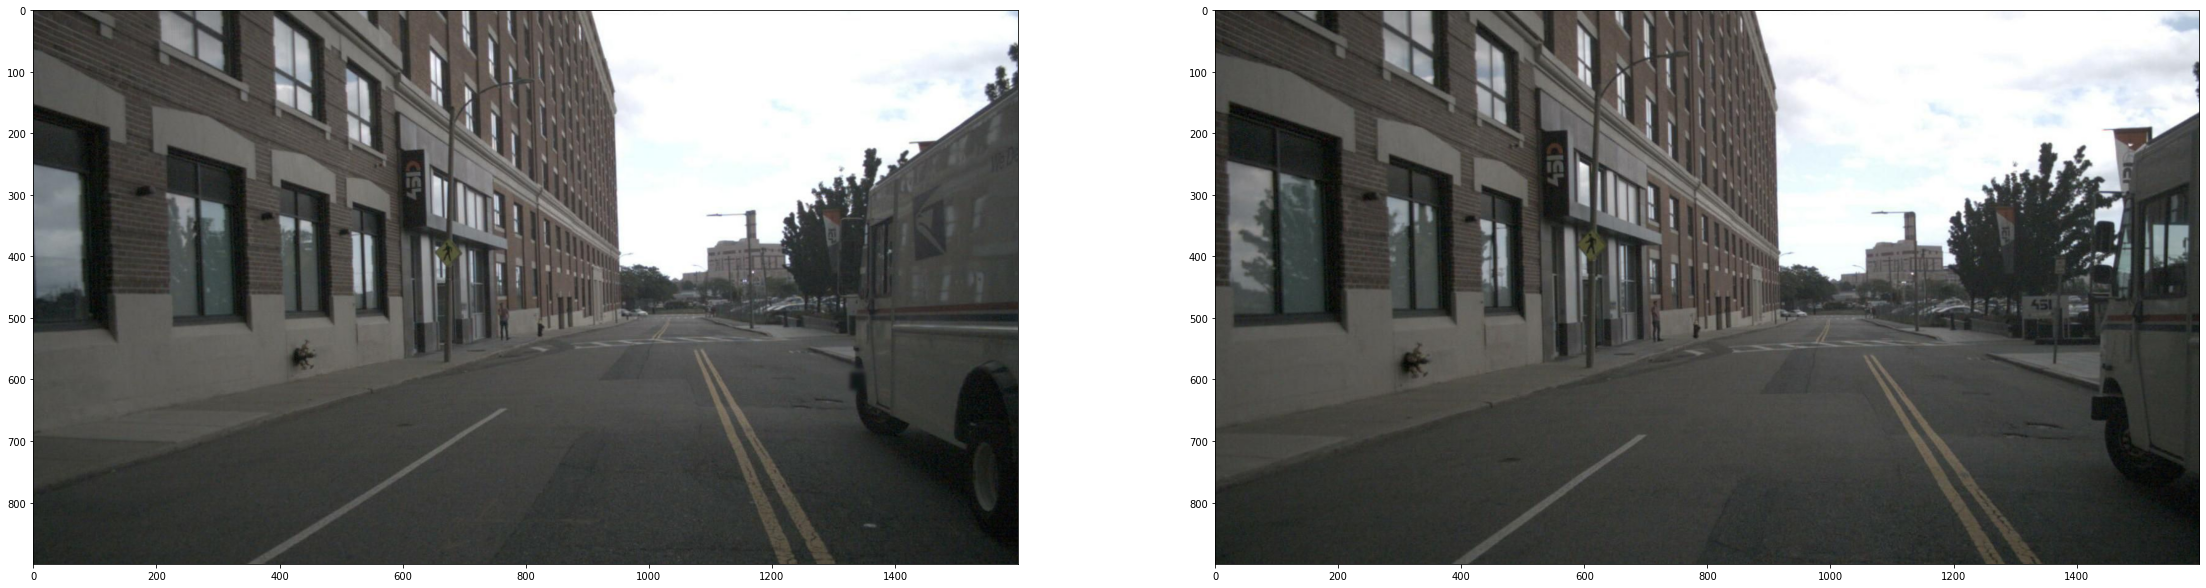

In [10]:
show_images(data_dir, list(resultImages.keys()), sample=10)

image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492112404.jpg
loaded


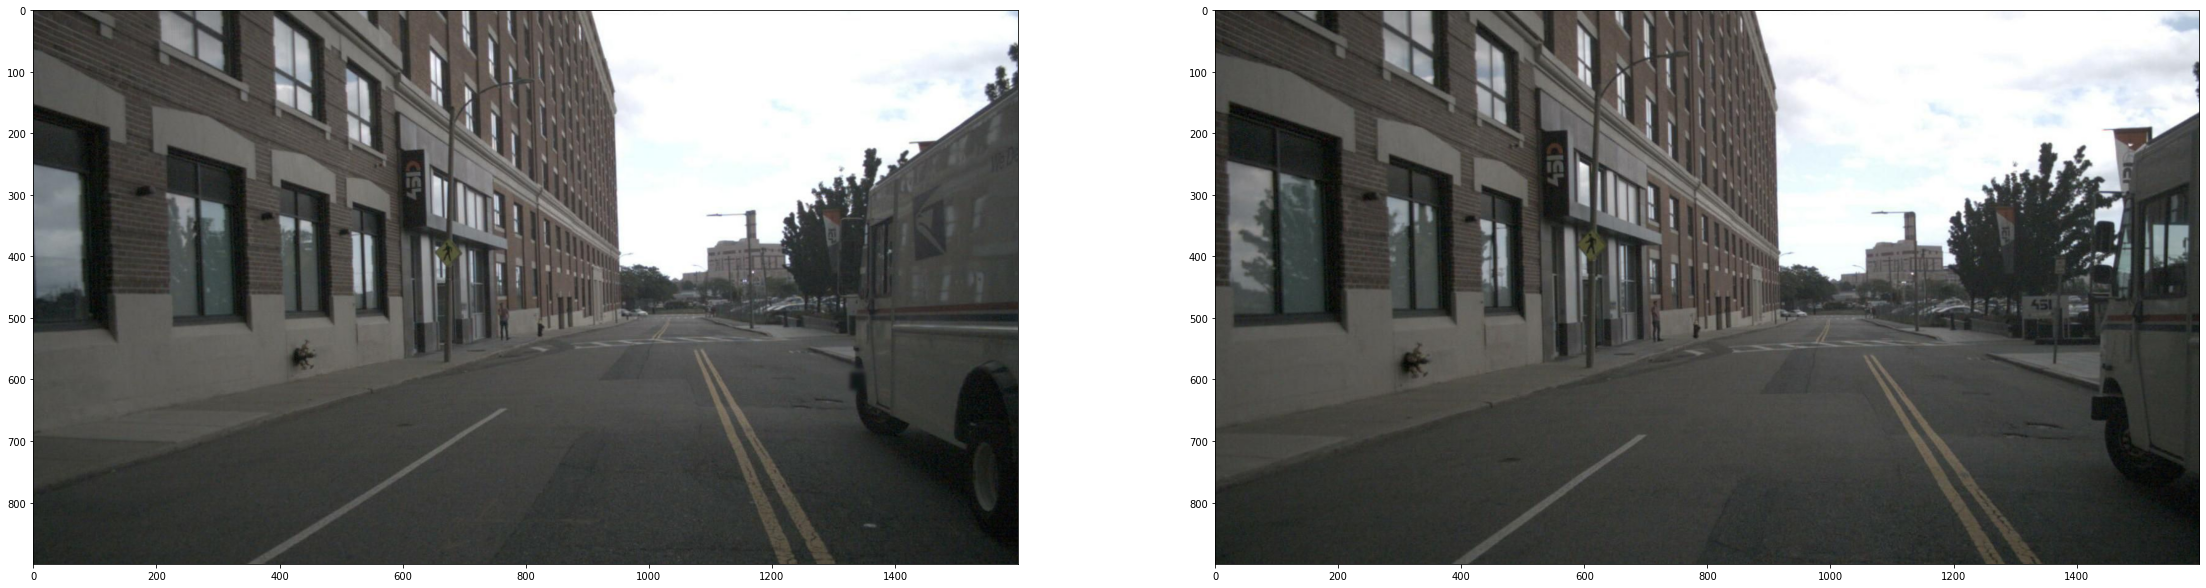

In [11]:
expected_imgs = [
    "n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg",
    "n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492112404.jpg"
]
show_images(data_dir, expected_imgs, sample=10)

In [12]:
### Getting info about the expected images
from apperception.database import database
for img in expected_imgs:
    prefix = "samples/CAM_FRONT/"
    query = f"""SELECT Distinct \'Cameras: \', Cameras.filename, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), 
    Cameras.egoHeading, facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp),
     ST_X(Cameras.egoTranslation), ST_Y(Cameras.egoTranslation), ST_Z(Cameras.egoTranslation),
    \'Cars: \', table_0.itemId, getX(table_0.trajCentroids, Cameras.timestamp), getY(table_0.trajCentroids, Cameras.timestamp), 
    ST_Z(valueAtTimestamp(table_0.trajCentroids, Cameras.timestamp)), 
    \'Distance: \', distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp),
    \'CarHeading:\', valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp),
    \'RoadDirection for car:\', roadDirection(table_0.trajCentroids, Cameras.timestamp, valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp)::real),
    \'facingRelative:\', facingRelative(table_0.itemHeadings, roadDirection(table_0.trajCentroids, Cameras.timestamp, valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp)::real), Cameras.timestamp) 
    FROM Item_General_Trajectory AS table_0, Cameras
                WHERE Cameras.filename = \'{prefix + img}\' AND table_0.cameraId = Cameras.cameraId AND table_0.objectType LIKE 'vehicle%'"""
    database.cursor.execute(query)
    result = database.cursor.fetchall()
    print(result)

UndefinedFunction: function getx(tgeompoint, timestamp with time zone) does not exist
LINE 4:     'Cars: ', table_0.itemId, getX(table_0.trajCentroids, Ca...
                                      ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.


In [ ]:
from apperception.database import database
query = f"""SELECT elementId FROM SegmentPolygon WHERE contained(st_point(1269.1763045216746, 911.0066718975124), elementPolygon)
            AND (SELECT id FROM Road WHERE id = elementId) IS NOT NULL;"""
database.cursor.execute(query)
result = database.cursor.fetchall()
print(result)

In [ ]:
from apperception.database import database
query = f"""SELECT ST_Distance(st_point(1269.1763045216746, 911.0066718975124), st_point(1248.3893859608852, 947.7008533706982));"""
database.cursor.execute(query)
result = database.cursor.fetchall()
print(result)

In [ ]:
122.09787+48.640766

In [ ]:
360-(122.09787+48.640766)